In [1]:
import os
import sys
import string
import numpy as np
from pickle import dump
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, GRU

In [2]:
# path to text file
doc_path = "drive/MyDrive/Newcastle University/Deep Learning/Data/61262-0.txt"

In [3]:
# Function used to plot the curves for loss and accuracy:
def plot_curves(history):

  # Plotting the loss curve:
  plt.subplot()
  plt.title('Cross Entropy')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  # Plotting the training loss (blue):
  plt.plot(history.history['loss'], color='red', label='train')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  # Legend for the plot:
  plt.legend(['loss', 'acc'], loc='upper left')
  plt.show()

print('Done!')

Done!


In [4]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

In [5]:
# function to convert a document into clean tokens
def clean_doc(doc):
	# replacing '--' with a space ' '
	doc = doc.replace('--', ' ')
	# splitting into tokens by white space
	tokens = doc.split()
	# removing punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
	# removing non-alphabetic tokens
	tokens = [word for word in tokens if word.isalpha()]
	# converting to lower case
	tokens = [word.lower() for word in tokens]
	return tokens

In [6]:
# function to save tokens to file, one dialog per line
def save_doc(lines, filename):
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [7]:
# loading the document
doc = load_doc(doc_path)
print(doc[:300])

﻿The Project Gutenberg EBook of Poirot Investigates, by Agatha Christie

This eBook is for the use of anyone anywhere in the United States and most
other parts of the world at no cost and with almost no restrictions
whatsoever.  You may copy it, give it away or re-use it under the terms of
the Proje


In [8]:
# getting total length of the document
print('total length of the document:', len(doc), 'characters')

# getting a list of all the unique words in the document
characters = sorted(list(set(doc)))
print('total unique characters:', len(characters))

total length of the document: 316568 characters
total unique characters: 104


In [9]:
print(doc[1500:1666])

Prime Minister

  IX The Disappearance of Mr. Davenheim

  X The Adventure of the Italian Nobleman

  XI The Case of the Missing Will




  POIROT INVESTIGATES




  


In [10]:
print(doc[1666:2000])

POIROT INVESTIGATES


  I


  The Adventure of “The Western Star”

I was standing at the window of Poirot’s rooms looking out idly on
the street below.

“That’s queer,” I ejaculated suddenly beneath my breath.

“What is, _mon ami_?” asked Poirot placidly, from the depths of
his comfortable chair.

“Deduce, Poirot, from the following


In [11]:
print(doc[-20000:-18970])

 He foresaw every step that a searcher
would take—that I, miserable imbecile, took. He gets two will-forms,
makes the servants sign twice, then sallies out with his will
written on the inside of a dirty envelope and a fountain-pen
containing his little ink mixture. On some excuse he gets the
confectioner and his wife to sign their names under his own
signature, then he ties it to the key of his desk and chuckles to
himself. If his niece sees through his little ruse, she will have
justified her choice of life and elaborate education, and be
thoroughly welcome to his money.”

“She didn’t see through it, did she?” I said slowly. “It seems
rather unfair. The old man really won.”

“But no, Hastings. It is _your_ wits that go astray. Miss Marsh
proved the astuteness of her wits and the value of the higher
education for women by at once putting the matter in _my_ hands.
Always employ the expert. She has amply proved her right to the
money.”

I wonder—I very much wonder—what old Andrew Marsh w

In [12]:
# removing disclaimer and text not part of the novel contents
doc = doc[1666:-18970]

In [13]:
print('First 100 characters\n\n', doc[:1000])
print('\n\nLast 1000 characters\n\n', doc[-1000:])

First 100 characters

 POIROT INVESTIGATES


  I


  The Adventure of “The Western Star”

I was standing at the window of Poirot’s rooms looking out idly on
the street below.

“That’s queer,” I ejaculated suddenly beneath my breath.

“What is, _mon ami_?” asked Poirot placidly, from the depths of
his comfortable chair.

“Deduce, Poirot, from the following facts! Here is a young lady,
richly dressed—fashionable hat, magnificent furs. She is coming
along slowly, looking up at the houses as she goes. Unknown to her,
she is being shadowed by three men and a middle-aged woman. They
have just been joined by an errand boy who points after the girl,
gesticulating as he does so. What drama is this being played? Is
the girl a crook, and are the shadowers detectives preparing to
arrest her? Or are _they_ the scoundrels, and are they plotting to
attack an innocent victim? What does the great detective say?”

“The great detective, _mon ami_, chooses, as ever, the simplest
course. He rises to see fo

In [14]:
# cleaning document
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['poirot', 'investigates', 'i', 'the', 'adventure', 'of', 'western', 'i', 'was', 'standing', 'at', 'the', 'window', 'of', 'rooms', 'looking', 'out', 'idly', 'on', 'the', 'street', 'below', 'i', 'ejaculated', 'suddenly', 'beneath', 'my', 'breath', 'is', 'mon', 'asked', 'poirot', 'placidly', 'from', 'the', 'depths', 'of', 'his', 'comfortable', 'chair', 'poirot', 'from', 'the', 'following', 'facts', 'here', 'is', 'a', 'young', 'lady', 'richly', 'hat', 'magnificent', 'furs', 'she', 'is', 'coming', 'along', 'slowly', 'looking', 'up', 'at', 'the', 'houses', 'as', 'she', 'goes', 'unknown', 'to', 'her', 'she', 'is', 'being', 'shadowed', 'by', 'three', 'men', 'and', 'a', 'middleaged', 'woman', 'they', 'have', 'just', 'been', 'joined', 'by', 'an', 'errand', 'boy', 'who', 'points', 'after', 'the', 'girl', 'gesticulating', 'as', 'he', 'does', 'so', 'what', 'drama', 'is', 'this', 'being', 'played', 'is', 'the', 'girl', 'a', 'crook', 'and', 'are', 'the', 'shadowers', 'detectives', 'preparing', 'to',

In [15]:
# organizing into sequences of tokens
length = 30 + 1
sequences = list()
for i in range(length, len(tokens)):
	# select sequence of tokens
	seq = tokens[i-length:i]
	# convert into a line
	line = ' '.join(seq)
	# store
	sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 47878


In [15]:
len(sequences)
#sys.getsizeof(sequences)

47878

In [16]:
np.shape(sequences)

(47878,)

In [16]:
sequences[1]

'investigates i the adventure of western i was standing at the window of rooms looking out idly on the street below i ejaculated suddenly beneath my breath is mon asked poirot'

In [17]:
# save sequences to file
out_filename = 'drive/MyDrive/Newcastle University/Deep Learning/Data/piorot_investigates.txt'
save_doc(sequences, out_filename)

# loading the sequence from file
doc = load_doc(out_filename)
lines = doc.split('\n')

In [18]:
# integer encode sequences of words
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sequences)
sequences = tokenizer.texts_to_sequences(sequences)

In [ ]:
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [19]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size

5596

In [20]:
# separate into input and output
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]
seq_length

30

# Model 1

Model 1 only has one LSTM layer followed by a classification layer

In [41]:
# define model
model_1 = Sequential()
model_1.add(Embedding(vocab_size, 30, input_length=seq_length))
model_1.add(LSTM(128))
model_1.add(Dense(vocab_size, activation='softmax'))

In [42]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 30)            167880    
                                                                 
 lstm_4 (LSTM)               (None, 128)               81408     
                                                                 
 dense_4 (Dense)             (None, 5596)              721884    
                                                                 
Total params: 971,172
Trainable params: 971,172
Non-trainable params: 0
_________________________________________________________________


In [43]:
sgd = keras.optimizers.SGD(learning_rate=0.002)
adam = keras.optimizers.Adam(0.02)
nadam = keras.optimizers.Nadam(learning_rate=0.002)

In [44]:
# compile model
model_1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# fit model
history = model_1.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
337/337 [==============================] - 6s 11ms/step - loss: 6.6676 - accuracy: 0.0627 - val_loss: 6.6060 - val_accuracy: 0.0620
Epoch 2/100
337/337 [==============================] - 3s 9ms/step - loss: 6.2456 - accuracy: 0.0732 - val_loss: 6.5532 - val_accuracy: 0.0796
Epoch 3/100
337/337 [==============================] - 3s 9ms/step - loss: 6.0302 - accuracy: 0.0845 - val_loss: 6.5147 - val_accuracy: 0.0871
Epoch 4/100
337/337 [==============================] - 3s 9ms/step - loss: 5.8409 - accuracy: 0.0956 - val_loss: 6.4820 - val_accuracy: 0.0911
Epoch 5/100
337/337 [==============================] - 3s 9ms/step - loss: 5.6678 - accuracy: 0.1039 - val_loss: 6.4931 - val_accuracy: 0.0936
Epoch 6/100
337/337 [==============================] - 3s 9ms/step - loss: 5.5048 - accuracy: 0.1114 - val_loss: 6.5019 - val_accuracy: 0.0998
Epoch 7/100
337/337 [==============================] - 3s 9ms/step - loss: 5.3414 - accuracy: 0.1217 - val_loss: 6.5323 - val_accuracy: 0.102

In [46]:
# save the model to file
model_1.save('drive/MyDrive/Newcastle University/Deep Learning/Models/Language_Model_1.1.h5')

In [ ]:
plot_curves(history)

# Model 2

Model 2 only has 2 LSTM layers followed by a dense and a classification layer

In [47]:
# define model
model_2 = Sequential()
model_2.add(Embedding(vocab_size, 30, input_length=seq_length))
model_2.add(LSTM(128, return_sequences=True))
model_2.add(LSTM(256))
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(vocab_size, activation='softmax'))

In [48]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 30)            167880    
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           81408     
                                                                 
 lstm_6 (LSTM)               (None, 256)               394240    
                                                                 
 dense_5 (Dense)             (None, 100)               25700     
                                                                 
 dense_6 (Dense)             (None, 5596)              565196    
                                                                 
Total params: 1,234,424
Trainable params: 1,234,424
Non-trainable params: 0
_________________________________________________________________


In [49]:
sgd = keras.optimizers.SGD(learning_rate=0.002)
adam = keras.optimizers.Adam(0.002)
nadam = keras.optimizers.Nadam(learning_rate=0.002)

In [50]:
# compile model
model_2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# fit model
history = model_2.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
375/375 [==============================] - 8s 14ms/step - loss: 6.6589 - accuracy: 0.0599
Epoch 2/100
375/375 [==============================] - 5s 13ms/step - loss: 6.2281 - accuracy: 0.0692
Epoch 3/100
375/375 [==============================] - 5s 13ms/step - loss: 6.0314 - accuracy: 0.0772
Epoch 4/100
375/375 [==============================] - 5s 13ms/step - loss: 5.8747 - accuracy: 0.0854
Epoch 5/100
375/375 [==============================] - 5s 12ms/step - loss: 5.7580 - accuracy: 0.0943
Epoch 6/100
375/375 [==============================] - 5s 12ms/step - loss: 5.6381 - accuracy: 0.0994
Epoch 7/100
375/375 [==============================] - 5s 12ms/step - loss: 5.5413 - accuracy: 0.1039
Epoch 8/100
375/375 [==============================] - 5s 12ms/step - loss: 5.4553 - accuracy: 0.1090
Epoch 9/100
375/375 [==============================] - 5s 12ms/step - loss: 5.3745 - accuracy: 0.1119
Epoch 10/100
375/375 [==============================] - 5s 12ms/step - loss: 5.326

In [52]:
# save the model to file
model_2.save('drive/MyDrive/Newcastle University/Deep Learning/Models/Language_Model_2.h5')

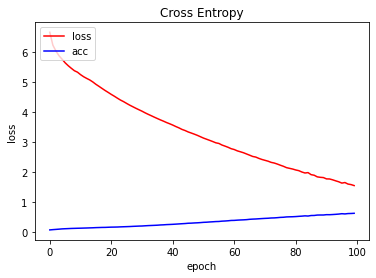

In [59]:
plot_curves(history)

# Model 3

Model 3 only has 1 GRU layers followed by a dense and a classification layer

In [64]:
# define model
model_3 = Sequential()
model_3.add(Embedding(vocab_size, 30, input_length=seq_length))
model_3.add(GRU(256))
model_3.add(Dense(vocab_size, activation='softmax'))

In [65]:
model_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 30, 30)            167880    
                                                                 
 gru_1 (GRU)                 (None, 256)               221184    
                                                                 
 dense_10 (Dense)            (None, 5596)              1438172   
                                                                 
Total params: 1,827,236
Trainable params: 1,827,236
Non-trainable params: 0
_________________________________________________________________


In [66]:
sgd = keras.optimizers.SGD(learning_rate=0.002)
adam = keras.optimizers.Adam(0.002)
nadam = keras.optimizers.Nadam(learning_rate=0.002)

In [67]:
# compile model
model_3.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# fit model
history = model_3.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
375/375 [==============================] - 5s 9ms/step - loss: 6.7761 - accuracy: 0.0649
Epoch 2/100
375/375 [==============================] - 3s 9ms/step - loss: 6.0134 - accuracy: 0.0895
Epoch 3/100
375/375 [==============================] - 4s 9ms/step - loss: 5.6122 - accuracy: 0.1158
Epoch 4/100
375/375 [==============================] - 3s 9ms/step - loss: 5.2079 - accuracy: 0.1357
Epoch 5/100
375/375 [==============================] - 3s 9ms/step - loss: 4.7143 - accuracy: 0.1572
Epoch 6/100
375/375 [==============================] - 4s 9ms/step - loss: 4.1319 - accuracy: 0.2009
Epoch 7/100
375/375 [==============================] - 4s 10ms/step - loss: 3.5124 - accuracy: 0.2834
Epoch 8/100
375/375 [==============================] - 4s 10ms/step - loss: 2.9684 - accuracy: 0.3715
Epoch 9/100
375/375 [==============================] - 3s 9ms/step - loss: 2.5400 - accuracy: 0.4474
Epoch 10/100
375/375 [==============================] - 3s 9ms/step - loss: 2.1955 - accu

In [68]:
# save the model to file
model_3.save('drive/MyDrive/Newcastle University/Deep Learning/Models/Language_Model_3.h5')

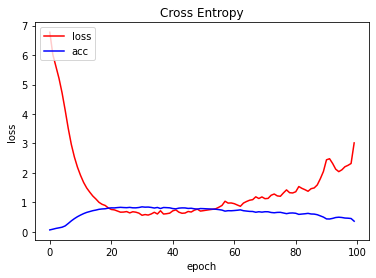

In [69]:
plot_curves(history)

# Model 4

Model 4 has 2 GRU layers followed by a dense and a classification layer

In [70]:
# define model
model_4 = Sequential()
model_4.add(Embedding(vocab_size, 30, input_length=seq_length))
model_4.add(GRU(128, return_sequences=True))
model_4.add(GRU(256))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(vocab_size, activation='softmax'))

In [71]:
model_4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 30, 30)            167880    
                                                                 
 gru_2 (GRU)                 (None, 30, 128)           61440     
                                                                 
 gru_3 (GRU)                 (None, 256)               296448    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 5596)              721884    
                                                                 
Total params: 1,280,548
Trainable params: 1,280,548
Non-trainable params: 0
_________________________________________________________________


In [72]:
sgd = keras.optimizers.SGD(learning_rate=0.002)
adam = keras.optimizers.Adam(0.002)
nadam = keras.optimizers.Nadam(learning_rate=0.002)

In [73]:
# compile model
model_4.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# fit model
history = model_4.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
375/375 [==============================] - 7s 12ms/step - loss: 6.6510 - accuracy: 0.0582
Epoch 2/100
375/375 [==============================] - 4s 12ms/step - loss: 6.2235 - accuracy: 0.0717
Epoch 3/100
375/375 [==============================] - 4s 12ms/step - loss: 5.9905 - accuracy: 0.0820
Epoch 4/100
375/375 [==============================] - 4s 12ms/step - loss: 5.7659 - accuracy: 0.0957
Epoch 5/100
375/375 [==============================] - 4s 12ms/step - loss: 5.5524 - accuracy: 0.1100
Epoch 6/100
375/375 [==============================] - 4s 12ms/step - loss: 5.3725 - accuracy: 0.1209
Epoch 7/100
375/375 [==============================] - 4s 12ms/step - loss: 5.1929 - accuracy: 0.1323
Epoch 8/100
375/375 [==============================] - 4s 12ms/step - loss: 5.0221 - accuracy: 0.1428
Epoch 9/100
375/375 [==============================] - 4s 12ms/step - loss: 4.8552 - accuracy: 0.1537
Epoch 10/100
375/375 [==============================] - 4s 12ms/step - loss: 4.691

In [74]:
# save the model to file
model_4.save('drive/MyDrive/Newcastle University/Deep Learning/Models/Language_Model_4.h5')

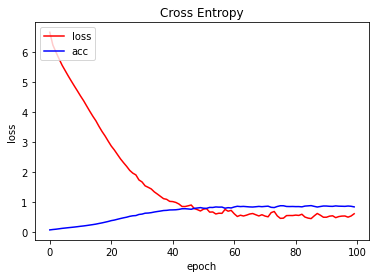

In [75]:
plot_curves(history)